# Stage 2
For Stage 2 we now consider the parabolic equation
ut=∇⋅(σ(x,y)∇)u
 
with the same space domain as in Stage 1 and time  t
  starting at  0
 . Initial conditions are given as  u(x,y,0)=g(x,y)
  at time  t=0
  and  u(x,y,t)=0
  on the boundary for all  t≥0
 . For stage 2 you are asked to develop an OpenCL implementation of this parabolic PDE. For the time discretisation you can use a simple forward difference scheme given as
ut(x,y)≈u(x,y,t+Δt)−u(x,y,t)Δt.
 
Demonstrate the time-domain solver for some interesting choices of initial conditions and a given random field for  σ
  as in Stage 1. Also consider the time discretisation  Δt
  and experiment with it. This is a realistic simulation of a time-dependent diffusion process in two dimensions. a good initial condition is to put some weight into the middle of the domain and observe how it slowly diffuses in time.
For Stage 2 performance is relevant. Your solution must contain a directly runnable command that measures the time of performing 10 forward time steps and returns the results in seconds. For this write a Python function that takes the current iterate and performs one forward time step with your OpenCL implementation. The function should then be called 10 times in your performance measurements. I need to be able to directly run your benchmarking code.

# The benchmarking code is 'timing_1_ten' function I've defined after running functions section (2)

In [1]:
"""!conda install -c conda-forge --yes --verbose pyopencl pocl"""

'!conda install -c conda-forge --yes --verbose pyopencl pocl'

# Table of contents
(1) Codes for the methods <br>
(2) Code to Benchmark <br>
(2) (a) timing gives average<br>
(2) (b) timing_ten gives commulative <br>
(2) (c) timing_1_ten gives commulative for t=1 <br>
(3) Simple example of the code<br>
(4) Getting the diffusion rate<br>
(5) (low cost example of) Trial and error for getting constant C<br>

# (1) This part is just defining all the codes first


In [2]:
"""First importing everyhing"""
import pyopencl as cl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy.stats

import time

I write a random sigma functions like the stage one to get the random sigma <br>
I write a gaussian function for the gaussian initial condition I'll be using. It uses scipy.stats

In [3]:
def sigma_random(N):
    """Getting the sigma values, randomly distributed"""
    mean = 0
    std = 0.1
    np.random.seed(1)

    return np.array(np.exp(-np.random.normal(mean, std, N**2)), dtype=np.float32)

def gaussian(N):
    """Gaussian Initial conditions"""
    mean=tuple([0.5, 0.5])
    variance=tuple([0.1, 0.1])
    x = np.arange(0, 1, 1/N)
    y = np.arange(0, 1, 1/N)
    x_axis, y_axis = np.meshgrid(x, y)

    mean_pdf = np.column_stack([x_axis.flat, y_axis.flat])
    mean_g = np.array(mean)
    std = np.array(variance)
    covariance = np.diag(std*std)
    G = scipy.stats.multivariate_normal.pdf(mean_pdf, mean=mean_g, cov=covariance)
    
    for i in range(N):
        for j in range(N):
            if i==0 or i==N-1 or j==0 or j==N-1:
                G[i*N +j] = 0 
    return np.array(G, dtype=np.float32)

In [4]:
"""The actual function running the code
The AAA and C variables are bad practice used for trial and error
for the time-step size. In the initial script they were used.
Unless C is defined again, the function
will use 1/6 as the constant used to calculate the step-size
"""

AAA=1/6
C=AAA
C=1/6

def RUN(sigma, u0, N, t):
    # Context
    ctx  = cl.create_some_context()
    queue=cl.CommandQueue(ctx)
    mf   = cl.mem_flags
    
    # my kernel
    kernel = """
    __kernel void Operator(__global float* u0,
                            __global float* u1,
                             const __global float* sigma,
                             const float dt) {



        // I is for u1 and J is for u0
        const int I = get_global_id(1);
        const int J = get_global_id(0);
        
        // M is for u1 and N is for u0
        const int M = get_global_size(1);
        const int N = get_global_size(0);

        // spatial-step size
        const double h = 1./M;



        if (I == 0 || I == M-1 || J == 0 || J == N-1) {
                // Dirichlet 
                u1[I*M+J] = 0; } else {
                
                double SIP; double SIM; double SJP; double SJM;

                double uij; double uip; double uim; double ujp; double ujm;

                SIP = 0.5 * (sigma[(I+1)*M + J] + sigma[I*M + J]);
                SIM = 0.5 * (sigma[(I-1)*M + J] + sigma[I*M + J]);
                SJP = 0.5 * (sigma[I*M +   J+1] + sigma[I*M + J]);
                SJM = 0.5 * (sigma[I*M +   J-1] + sigma[I*M + J]);

                uij = u0[I*M+J];
                uip = u0[(I+1)*M+J]; 
                uim = u0[(I-1)*M+J];
                ujp = u0[I*M+J+1];
                ujm = u0[I*M+J-1];

                u1[I*M+J] = u0[I*M+J] + dt/(h*h) 
                * ((SIP*(uip-uij) - SIM*(uij-uim)) +(SJP*(ujp-uij) - SJM*(uij-ujm)));

        }
        }
    """
    #buffers
    u0_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
    sigma_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=sigma)
    u1_buffer = cl.Buffer(ctx, mf.READ_WRITE, u0.nbytes)
    #getting the program
    prg = cl.Program(ctx, kernel)
    prg.build()
    kernel_diffusion = prg.Operator
    
    # The time-step size. I experimented later with the vlaue of C. default is 1/6
    dt = np.float32((1/N)*(1/N)*C)
    
    # loops over time steps
    for i in range(t):
        kernel_arguments = (u0_buffer, u1_buffer, sigma_buffer, dt)
        kernel_diffusion(queue, (N, N), None, *kernel_arguments)
        u0_buffer, u1_buffer = u1_buffer, u0_buffer
        
    result = np.empty_like(u0, dtype=np.float32)
    cl.enqueue_copy(queue, result, u0_buffer)
    
    return result

In [5]:
"""This script is used for plotting after run. It can run '3D' or '2D'"""
def PLOT(sigma, u0, N, t, figure_dimension):
    
    print(t)
    
    result = RUN(sigma, u0, N, t)
    result = result.reshape((N, N))
    
    if figure_dimension == '2D':
        plt.imshow(result, origin='lower', interpolation='none')
        
    elif figure_dimension=='3D':
        figure = plt.figure()
        plot_3 = Axes3D(figure)
        x = np.arange(0, 1, 1/N)
        y = np.arange(0, 1, 1/N)
        x_axis, y_axis = np.meshgrid(x, y)
        surf = plot_3.plot_surface(x_axis, y_axis, result, rstride=1,cstride=1, cmap='rainbow')
        plot_3.set_xlabel('x')
        plot_3.set_ylabel('y')
        plot_3.set_zlabel('solution')
        #figure.colorbar(surf, shrink=0.5, aspect=5)
    else:
        print("Misspelling with dimensions, 2D or 3D")

    plt.show()
    return result

# (2)This is the codes used for benchamrking
# timing gives average of 10 runs
# timing_ten gives commulative time for 10 runs
# timing_1_ten gives commulative time for 10 runs with t=1

In [6]:
# GIVES THE AVERAGE
def timing(func, *args, **kwargs):
    """Runs the function 10 times and gives the mean out"""
    time_vec = []
    for i in range(10):
        start = time.time()
        func(*args, **kwargs)
        time_vec.append(time.time()-start)

    return np.mean(time_vec)

N = 100
t =10
u0 = gaussian(N)
sigma = sigma_random(N)
print( "Mean time for 10 runs: {} seconds".format( timing(RUN, *(sigma, u0, N, t))))

Mean time for 10 runs: 0.11440174579620362 seconds


In [7]:
# GIVES ALL
def timing_ten(func, *args, **kwargs):
    start = time.time()
    for i in range(10):
        func(*args, **kwargs)
    return (time.time()-start)

N=100
t = 10
u0=gaussian(N)
sigma=sigma_random(N)

print( "Commulative time for 10 runs with 10 time-steps: {} seconds".format( timing_ten(RUN, *(sigma, u0, N, t))))
    

Commulative time for 10 runs with 10 time-steps: 0.04312634468078613 seconds


In [8]:
# Uses 10 of t=1
def timing_1_ten(func, *args, **kwargs):
    start = time.time()
    for i in range(10):
        func(*args, **kwargs)
    return (time.time()-start)

N=100
t = 1
u0=gaussian(N)
sigma=sigma_random(N)

print( "Commulative time for 10 runs with 1 time-steps: {} seconds".format( timing_1_ten(RUN, *(sigma, u0, N, t))))
    

Commulative time for 10 runs with 1 time-steps: 0.028412580490112305 seconds


# (3)Showing the code works

10


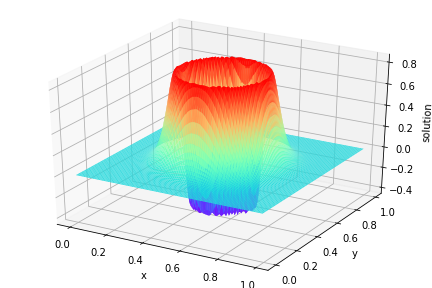

In [9]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

C=1/6
N = 100
t = 10
sigma = sigma_random(N)

u0 = gaussian(N)
u0 = np.sin(gaussian(N)) #wondered what sin of a Gaussian looks

a = PLOT(sigma, u0, N, t, '3D')


# (4) Getting the diffusion rate

100


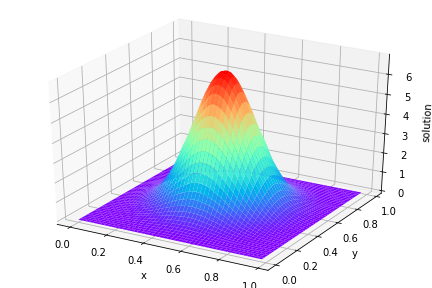

92.27893
200


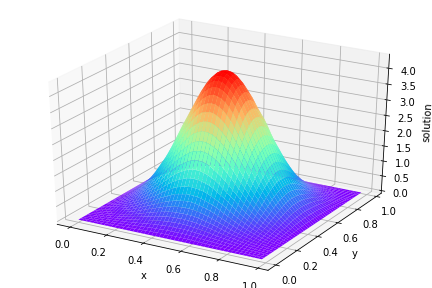

73.39208
300


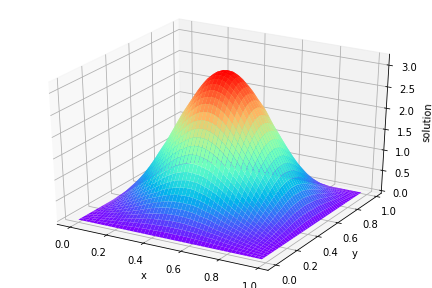

61.985245
400


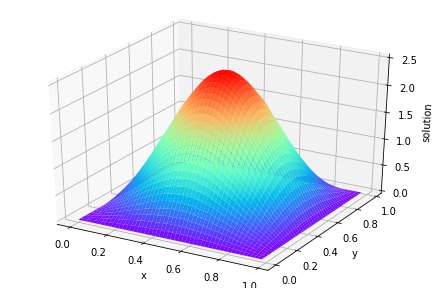

53.457615
500


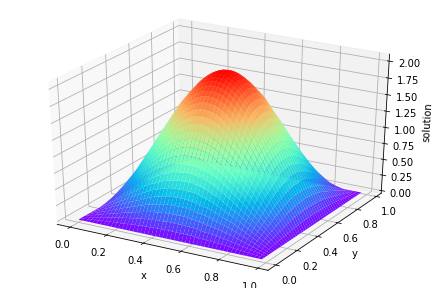

46.435078
600


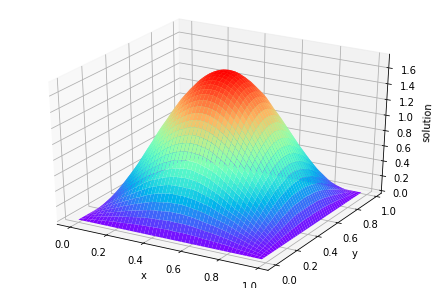

40.43368
700


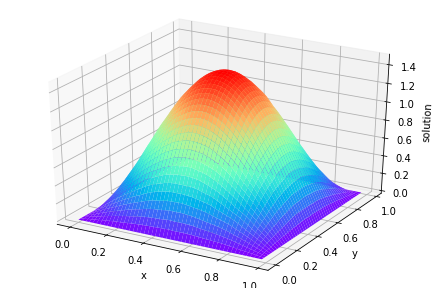

35.23741
800


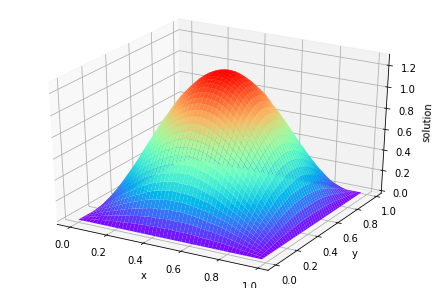

30.717943
900


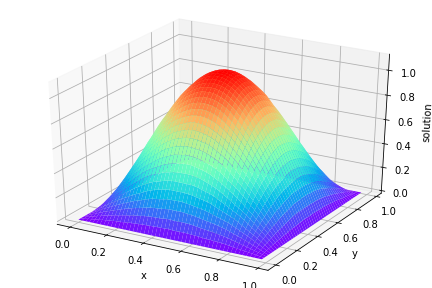

26.781008


In [10]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

data = []
step = []

N = 50
t = 10
sigma = sigma_random(N)

u0 = gaussian(N)
#u0 = np.sin(gaussian(N))
#u0 = np.ones(N*N)

for i in range(1,10,1):
    t = i*100
    result = PLOT(sigma, u0, N, t, '3D')
    
    data.append(np.linalg.norm(result))
    step.append(t)
    
    print(np.linalg.norm(result))
data_gaussian = data
step_gaussian = step

100


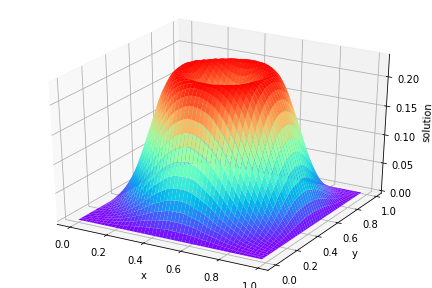

6.4977617
200


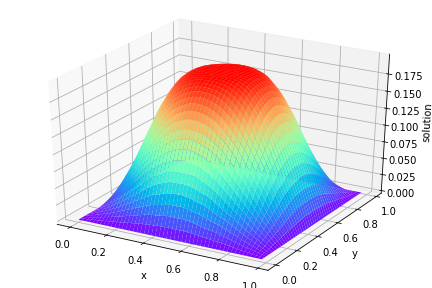

5.567276
300


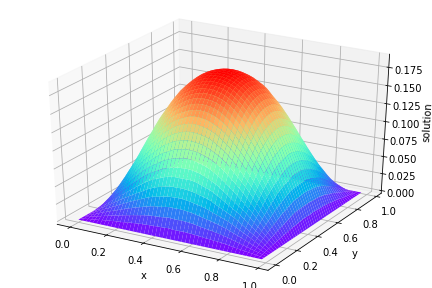

4.8459525
400


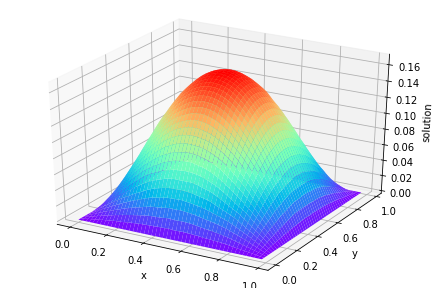

4.2239
500


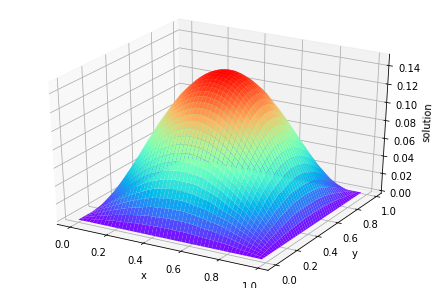

3.682443
600


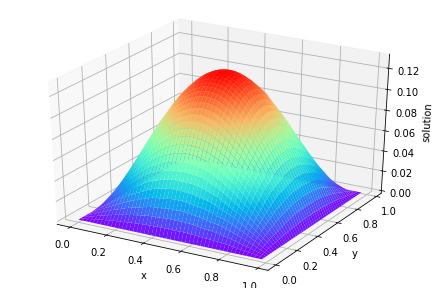

3.2105682
700


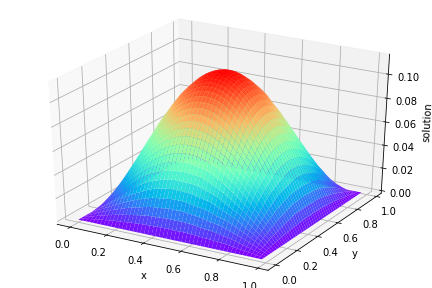

2.799225
800


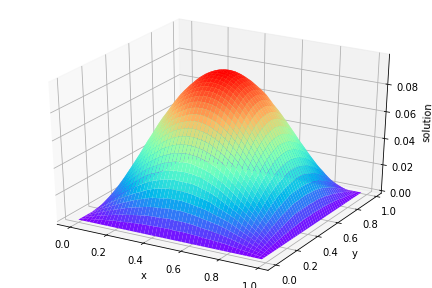

2.4406142
900


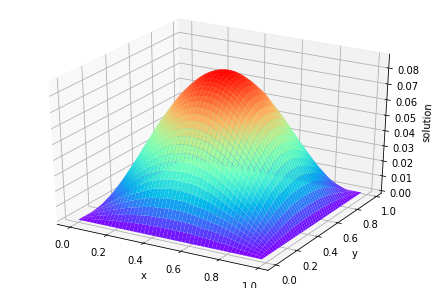

2.1279614


In [11]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

data = []
step = []

N = 50
t = 10
sigma = sigma_random(N)

#u0 = gaussian(N)
u0 = np.sin(gaussian(N))
#u0 = np.ones(N*N)

for i in range(1,10,1):
    t = i*100
    result = PLOT(sigma, u0, N, t, '3D')
    
    data.append(np.linalg.norm(result))
    step.append(t)
    
    print(np.linalg.norm(result))
data_sin_gaussian = data
step_sin_gaussian = step

100


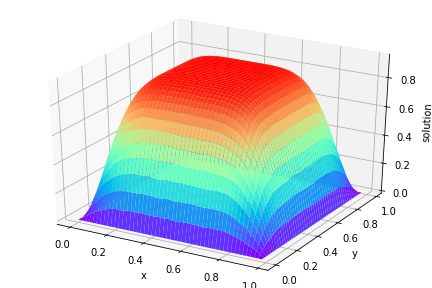

33.747593
200


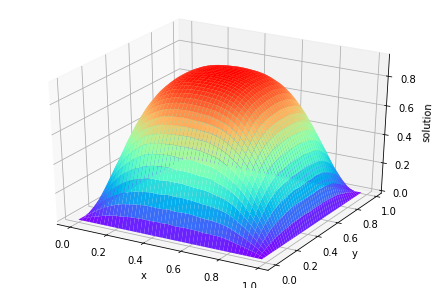

28.6786
300


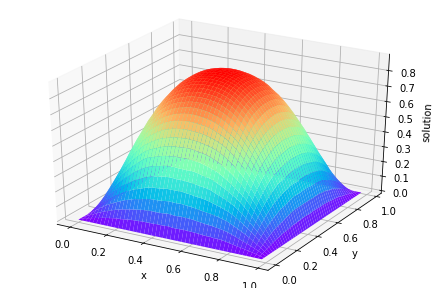

24.799503
400


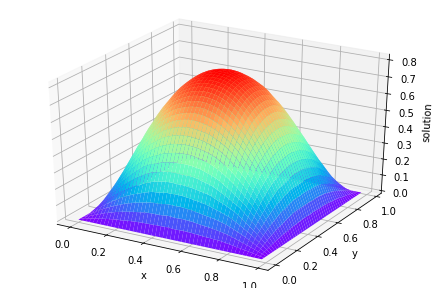

21.563566
500


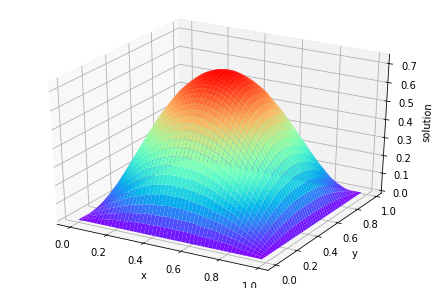

18.784239
600


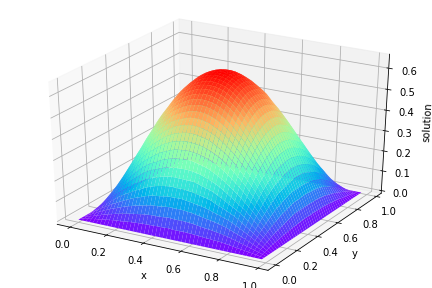

16.373129
700


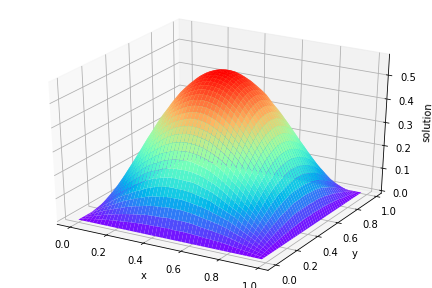

14.274408
800


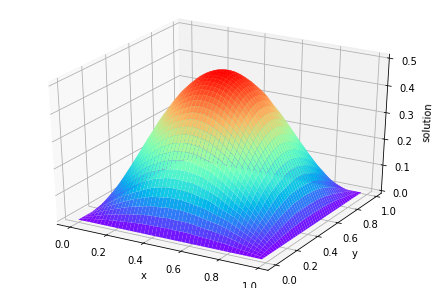

12.445546
900


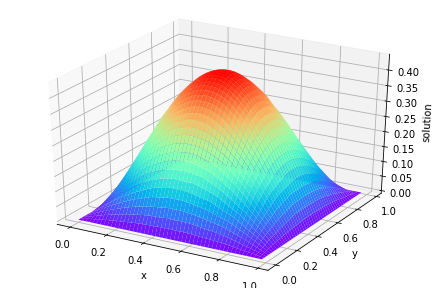

10.851246


In [12]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

data = []
step = []

N = 50
t = 10
sigma = sigma_random(N)

#u0 = gaussian(N)
#u0 = np.sin(gaussian(N))
u0 = np.ones(N*N)

for i in range(1,10,1):
    t = i*100
    result = PLOT(sigma, u0, N, t, '3D')
    
    data.append(np.linalg.norm(result))
    step.append(t)
    
    print(np.linalg.norm(result))
data_one = data
step_one = step

In [13]:
data_gaussian; 
step_gaussian;

data_sin_gaussian;
step_sin_gaussian;

data_one;
step_one;

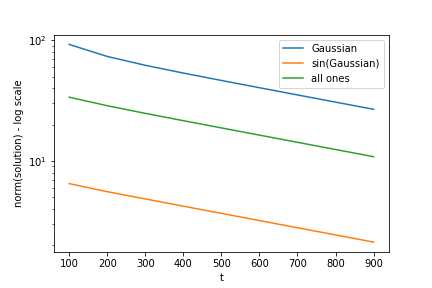

<Figure size 4000x3000 with 0 Axes>

In [14]:

plt.plot(step_gaussian, data_gaussian, label='Gaussian')
plt.plot(step_sin_gaussian, data_sin_gaussian, label='sin(Gaussian)')
plt.plot(step_one, data_one, label='all ones')
plt.legend()
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('norm(solution) - log scale')
plt.figure(figsize=(4,3), dpi=1000)
plt.show()

# (5) (low cost example of) Trial and error for getting constant C


The constant
0.35000000000000003
100


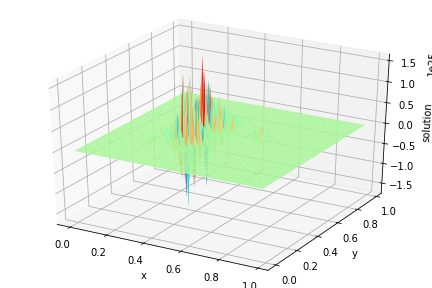

inf
The constant
0.33
100


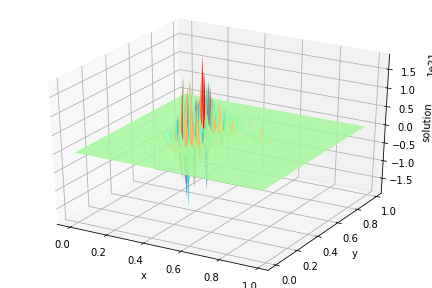

inf
The constant
0.31000000000000005
100


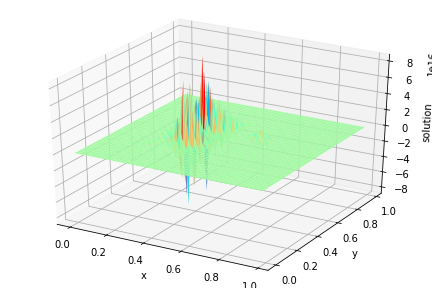

4.1374396e+17
The constant
0.29000000000000004
100


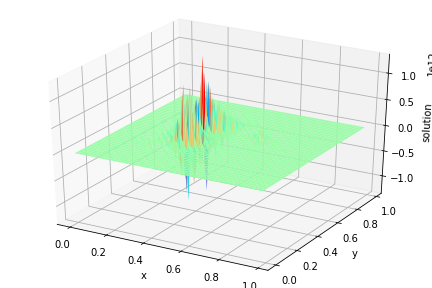

6107732400000.0
The constant
0.27
100


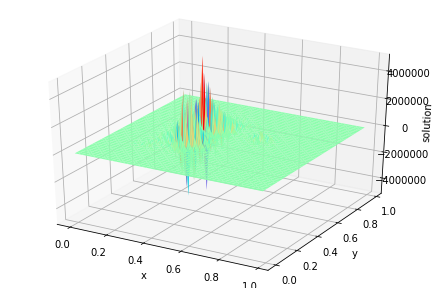

22444726.0
The constant
0.25
100


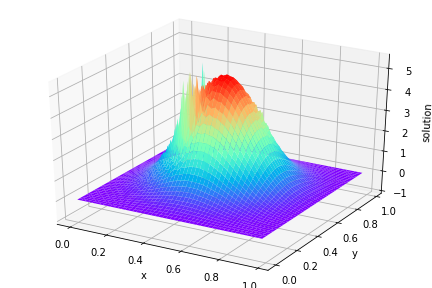

82.45589
The constant
0.23
100


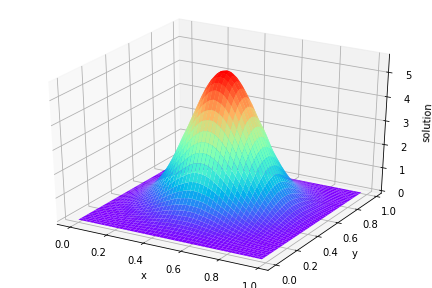

83.58032
The constant
0.21000000000000002
100


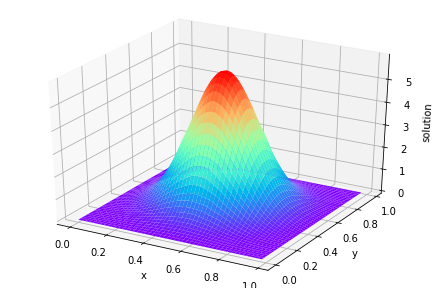

86.06323
The constant
0.19000000000000003
100


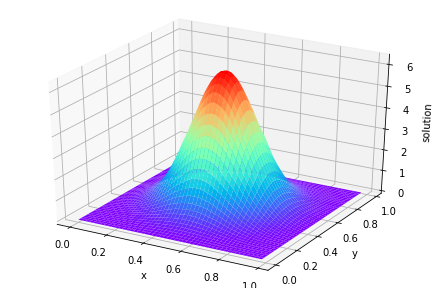

88.77424
The constant
0.17
100


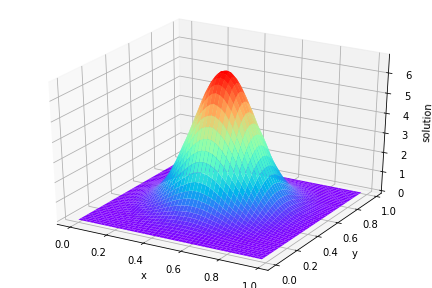

91.753105


In [15]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

""""""

data = []
step = []

N = 50
t = 10
sigma = sigma_random(N)

u0 = gaussian(N)
#u0 = np.sin(gaussian(N))
#u0 = np.ones(N*N)

for i in range(5,25,2):
    C = 0.4-0.01*i
    print("The constant")
    print(C)
    t = 100
    result = PLOT(sigma, u0, N, t, '3D')
    
    data.append(np.linalg.norm(result))
    step.append(t)
    
    print(np.linalg.norm(result))

In [16]:
C=1/6 #Making sure the C is set back and not used accidentally.